# Loan Data from Prosper 
## by Christian Altmoos

## Preliminary Wrangling

This data set contains `113,937` loans with `81` variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. The dataset contains so-called listings which either have been transformed to a loan or not. Partially funded loans are possible as well. My main overall interest might be why and who is becoming a so-called Prosper borrower and furthermore what is mainly influencing the interest rate. Interesting woould be how the average Prosper rate is compared to the normal finacial market. 

In [237]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from scipy.stats import norm


%matplotlib inline
warnings.filterwarnings("always")
sb.set(style="whitegrid")

### What is the structure of your dataset?

The overall structure can be found in this Google Docs [Spreadsheet](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit). Some further useful information I foud here:
* Prosper API Description [link](https://www.prosper.com/Downloads/Services/Documentation/ProsperDataExport_Details.html)
* Information on expected data types [link](https://bigml.com/user/mrlender/gallery/dataset/512e7695035d075e7c0000be)
* Expalanation Listing [link](https://www.prosper.com/invest/how-to-invest/search-listings/)
* Some articles to build up basic doamin knowledge:
    * Review Prosper [link1](https://www.bankrate.com/loans/personal-loans/reviews/prosper/)
    * Peer 2 Peer Lending vs. Bank Loan [link2](https://www.bankrate.com/loans/personal-loans/peer-to-peer-lending-vs-bank-loan/)
* Some fed data for interest rates [link](https://fred.stlouisfed.org/categories/101)

The data primarily consists out of 9 main categories, which obviously are merged in the given dataset.

* **Bid Object**: A Bid is created when a Lender wishes to lend money to a Borrower in response to a Listing the Borrower created to solicit Bids. Bids are created by specifying an Amount and a Minimum Rate in which the Lender wishes to receive should the Bid win the auction and become a Loan. The Minimum Rate remains private unless the Bid is Outbid by other Bids offering a lower Minimum Rate.

* **Category Object**: A Category is collection of Groups which share a common interest or affiliation. Categories are created by the Prosper Team. Group Leaders can associate their Group with one or more categories as they relate to their group. 

* **CreditProfile Object**: A CreditProfile is a timestamped set of extended credit information for a Member. Row level display and publication of CreditProfile is explicitly forbidden.

* **Group Object**: A Group is a collection of Members who share a common interest or affiliation. Groups are managed by Group Leaders who bring borrowers to Prosper, maintain the group's presence on the site, and collect and/or share Group Rewards. Borrowers who are members of a group often get better interest rates because Lenders tend to have more confidence in Borrowers that belong to trusted Groups. 

* **Listing Object**: A Listing is created by a Borrower to solicit bids by describing themselves and the reason they are looking to borrow money. If the Listing receives enough bids by Lenders to reach the Amount Requested then after the Listing period ends it will become a Loan. A Borrower may only have one active listing at a particular moment in time. 

* **Loan Object**: A Loan is created when a Borrower has received enough Bids to meet the full amount of money that the Borrower requested in their Listing. The Borrower must then make payments on the Loan to keep it's status current. 

* **Loan Performance Object**: A LoanPerformance is an event in a Loan History that causes a change in loan value. This table can be used to calculate roll rates. Row level display and publication of LoanPerformance is explicitly forbidden.

* **Marketplace Object**: The Marketplace is a collection of metrics and statistics about the Prosper Marketplace. These metrics are calculated daily. Historical metrics are provided as well. 

+ **Member Object**: A Member is a registered user of the Prosper Marketplace site. A Member may have one or multiple roles which determines which actions the Member is allowed to perform on the site. 



### What is/are the main feature(s) of interest in your dataset?

Based on  my high level questions I think these are the main attributes:

* Who is using Prosper? (basically which individuals, which proffessions, which part of the country)
    * Occupation
    * EmploymentStatus
    * IsBorrowerHomeowner
    * BorrowerState
* Why is Prosper used? (Is it related to rates, fess, or faster processing time)
    * ListingCategory
    * BorrowerAPR
    * BorrowerRate
    * ProsperRating 
* What is primarily influenicng the interest rate? (is it related to scoring, income and history)
    * ProsperRating (Alpha)
    * ProsperScore
    * DebtToIncomeRatio
    * IncomeRange
    

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?


I examined the stucture of the dataset utilizing the mentioned sources and categorized 3 main areas with the follwoing attributes. The main attributes are refrenced as `gray background`. I assume the other attributes are helping to explain variations and patterns obeserved in the data. However they might be not taken into consideration, depending on the anylsis.

* **Key and Date Attributes**
    * ListingNumber: The number that uniquely identifies the listing to the public as displayed on the website.
    * ListingCreationDate: The date the listing was created.
    * LoanOriginationDate: The date the loan was originated.
    * MemberKey: The unique key that is associated with the borrower. This is the same identifier that is used in the API member object. 
* **Loan Attributes**
    * ´ListingCategory´: The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans
    * ´BorrowerAPR`: The Borrower's Annual Percentage Rate (APR) for the loan.
    * `BorrowerRate´: The Borrower's interest rate for this loan. 
    * `ProsperRating (numeric`): The  Prosper Rating assigned at the time the listing was created: 0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA.  Applicable for loans originated after July 2009.
    * `ProsperRating (Alpha)`: The Prosper Rating assigned at the time the listing was created between AA - HR.  Applicable for loans originated after July 2009.
    * `ProsperScore`: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score.  Applicable for loans originated after July 2009.
    * Term: The length of the loan expressed in months.
    * LoanStatus: The current status of the loan: Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.
    * ClosedDate: Closed date is applicable for Cancelled, Completed, Chargedoff and Defaulted loan statuses. 
    * LoanOriginalAmount: The origination amount of the loan.
    * MonthlyLoanPayment: The scheduled monthly loan payment.
    * PercentFunded: Percent the listing was funded.
    * InvestmentFromFriendsCount: Number of friends that made an investment in the loan.
    * InvestmentFromFriendsAmount: Dollar amount of investments that were made by friends.
    * Investors: The number of investors that funded the loan.
* **Loan - Borrower Attributes** 
    * `DebtToIncomeRatio`: The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%).
    * `IncomeRange`: The income range of the borrower at the time the listing was created.
    * `Occupation`: The Occupation selected by the Borrower at the time they created the listing.
    * `EmploymentStatus`: The employment status of the borrower at the time they posted the listing.
    * `EmploymentStatusDuration`: The length in months of the employment status at the time the listing was created.
    * `IsBorrowerHomeowner`: A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.
    * `BorrowerState`: The two letter abbreviation of the state of the address of the borrower at the time the Listing was created.
    * CreditScoreRangeLower: The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
    * CreditScoreRangeUpper: The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency. 
    * CurrentCreditLines: Number of current credit lines at the time the credit profile was pulled.
    * OpenCreditLines: Number of open credit lines at the time the credit profile was pulled.
    * TotalCreditLinespast7years: Number of credit lines in the past seven years at the time the credit profile was pulled.
    * InquiriesLast6Months: Number of inquiries in the past six months at the time the credit profile was pulled.
    * CurrentDelinquencies: Number of accounts delinquent at the time the credit profile was pulled.
    * AmountDelinquent: Dollars delinquent at the time the credit profile was pulled.
    * DelinquenciesLast7Years: Number of delinquencies in the past 7 years at the time the credit profile was pulled.
    * RevolvingCreditBalance: Dollars of revolving credit at the time the credit profile was pulled.
    * BankcardUtilization: The percentage of available revolving credit that is utilized at the time the credit profile was pulled.
    * AvailableBankcardCredit: The total available credit via bank card at the time the credit profile was pulled.
    * IncomeVerifiable: The borrower indicated they have the required documentation to support their income.
    * StatedMonthlyIncome: The monthly income the borrower stated at the time the listing was created.
    * TotalProsperLoans: Number of Prosper loans the borrower at the time they created this listing. This value will be null if the borrower had no prior loans. 
    * TotalProsperPaymentsBilled: Number of on time payments the borrower made on Prosper loans at the time they created this listing. This value will be null if the borrower had no prior loans.
    * OnTimeProsperPayments: Number of on time payments the borrower had made on Prosper loans at the time they created this listing. This value will be null if the borrower has no prior loans.
    * ProsperPaymentsLessThanOneMonthLate: Number of payments the borrower made on Prosper loans that were less than one month late at the time they created this listing. This value will be null if the borrower had no prior loans. 
    * ProsperPaymentsOneMonthPlusLate: Number of payments the borrower made on Prosper loans that were greater than one month late at the time they created this listing. This value will be null if the borrower had no prior loans.
    * ProsperPrincipalBorrowed: Total principal borrowed on Prosper loans at the time the listing was created. This value will be null if the borrower had no prior loans.
    * ProsperPrincipalOutstanding: Principal outstanding on Prosper loans at the time the listing was created. This value will be null if the borrower had no prior loans.
    * ScorexChangeAtTimeOfListing: Borrower's credit score change at the time the credit profile was pulled. This will be the change relative to the borrower's last Prosper loan. This value will be null if the borrower had no prior loans.
    * Recommendations: Number of recommendations the borrower had at the time the listing was created.


## Gather Data 

In [3]:
# load the csv
df=pd.read_csv('prosperLoanData.csv')

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


### Some cleaning basic cleaning upfront

In [12]:
# harmonize and shrink the dataset based on the above mentioned rationales
# read the selected attributes
attr_2_be_del = pd.read_csv('Attributes_Not_Selected.csv')

In [15]:
# drop the columns not in favour
for attr in attr_2_be_del.Attributes:
    df.drop([attr], axis=1, inplace=True)

In [182]:
# rename some colums with blank values 
for column in df:
    df.rename(index=str, columns={column: column.replace(' ', '_')}, inplace=True)
    df.rename(index=str, columns={column: column.replace('(', '_')}, inplace=True)
    df.rename(index=str, columns={column: column.replace(')', '')}, inplace=True)

### Missing Values 

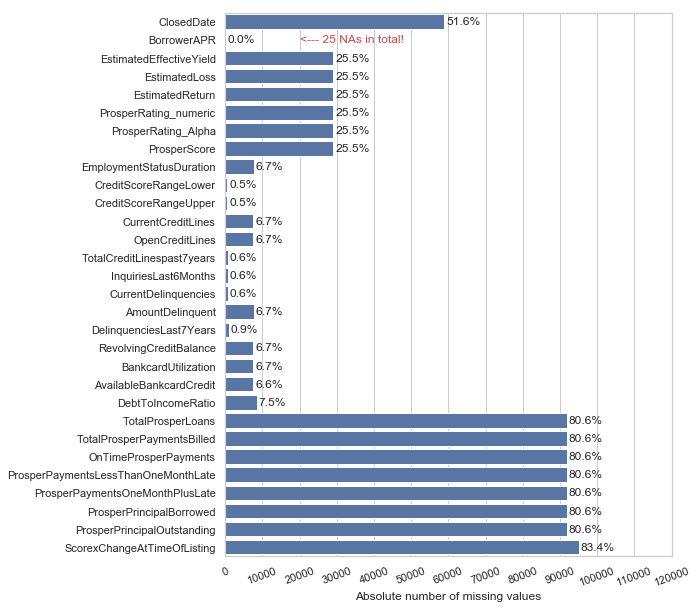

In [229]:
# Get an overview on the remaining colums
# set the base color
base_color = sb.color_palette()[0]

# plot a horizontal bar chart for missing values
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts>0]
plt.figure(figsize=(8,10))
sb.barplot(x=null_counts, y=np.arange(len(null_counts)), orient = 'h', color=base_color)
plt.xlabel('Absolute number of missing values')
plt.xticks(np.arange(0,130000,10000), rotation=20)
plt.yticks(np.arange(len(null_counts)),null_counts.index,rotation='horizontal');

# annotate with %
for i in np.arange(len(null_counts)):
    prop = null_counts[i]/len(df)
    if prop > 0:
        pct_string = '{:0.1f}%'.format(100*prop)
        #print(pct_string)
        plt.text(null_counts[i]+500, i, pct_string, va = 'center')
# annotate a small number>        
plt.text(20000, 1, '<--- 25 NAs in total!', va = 'center', color='r');

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113937 entries, 0 to 113936
Data columns (total 53 columns):
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating_numeric                  84853 non-null float64
ProsperRating_Alpha                    84853 non-null object
ProsperScore                           84853 non-null float64
ListingCategory_numeric    

`Comment`: Ok, let's comment and decide what to do?

* Occupation: 3.1 % -> Handle during Univariate / data type could be changed to categorial
* EmploymentStatus: 2% -> Handle during Univariate / data type could be changed to categorial
* BorrowerState: 4,8 -> Handle during Univariate / / data type could be changed to categorial
* BorrowerAPR: 25 in total -> Handle during Univariate / data type ok
* ProsperRating: only after July 2009, I believe this fact is the root cause of the 25,5% missing values  -> Handle during Univariate / data type ok
* ProsperRating (Alpha): same as above / data type ok
* ProsperScore: same as above / data type ok
* DebtToIncomeRatio: 7,5% -> Handle during Univariate / data type ok

Ther is fundamaental amount missing for closed date, which I believe is mainly die to the fact that the majority of loans are still running. Furthermore the section at the bottom, introduced bay TotalProspertLoans, TotalProsperPaymentBilled, etc. are aggregations based on historical data, hence if we haev first time lenders, those will be not filled. 

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

So move the univariate analysis for the main attributes and recall the questions I want to answer:

+ Who is using Prosper? (basically which individuals, which proffessions, which part of the country)
    + Occupation
    + EmploymentStatus
    + IsBorrowerHomeowner
    + BorrowerState
+ Why is Prosper used? (Is it related to rates, fess, or faster processing time)
    + ListingCategory
    + BorrowerAPR
    + BorrowerRate
    + ProsperRating
+ What is primarily influenicng the interest rate? (is it related to scoring, income and history)
    + ProsperRating (Alpha)
    + ProsperScore
    + DebtToIncomeRatio
    + IncomeRange

### Occupation

In [66]:
df.Occupation.value_counts()

Other                                 32205
Professional                          13628
Computer Programmer                    4478
Executive                              4311
Teacher                                3759
Administrative Assistant               3688
Analyst                                3602
Sales - Commission                     3446
Accountant/CPA                         3233
Clerical                               3164
Sales - Retail                         2797
Skilled Labor                          2746
Retail Management                      2602
Nurse (RN)                             2489
Construction                           1790
Truck Driver                           1675
Laborer                                1595
Police Officer/Correction Officer      1578
Civil Service                          1457
Engineer - Mechanical                  1406
Military Enlisted                      1272
Food Service Management                1239
Engineer - Electrical           

`Comment`: Oh my god, seems to be free text entry, actually not that bad. 67 different professions, majority is in _Others_, btw the missing values (3.1%) we can move 
 


In [72]:
# change Occupation NAs to "Others"
df['Occupation'][df['Occupation'].isnull()] = df.Occupation.value_counts().index[0];

In [70]:
df.Occupation.value_counts().isnull().sum()

0

In [82]:
df['Occupation'] = df['Occupation'].astype('category')

In [122]:
df.Occupation.dtype

CategoricalDtype(categories=['Accountant/CPA', 'Administrative Assistant', 'Analyst',
                  'Architect', 'Attorney', 'Biologist', 'Bus Driver',
                  'Car Dealer', 'Chemist', 'Civil Service', 'Clergy',
                  'Clerical', 'Computer Programmer', 'Construction', 'Dentist',
                  'Doctor', 'Engineer - Chemical', 'Engineer - Electrical',
                  'Engineer - Mechanical', 'Executive', 'Fireman',
                  'Flight Attendant', 'Food Service',
                  'Food Service Management', 'Homemaker', 'Investor', 'Judge',
                  'Laborer', 'Landscaping', 'Medical Technician',
                  'Military Enlisted', 'Military Officer', 'Nurse (LPN)',
                  'Nurse (RN)', 'Nurse's Aide', 'Other', 'Pharmacist',
                  'Pilot - Private/Commercial',
                  'Police Officer/Correction Officer', 'Postal Service',
                  'Principal', 'Professional', 'Professor', 'Psychologist',
          

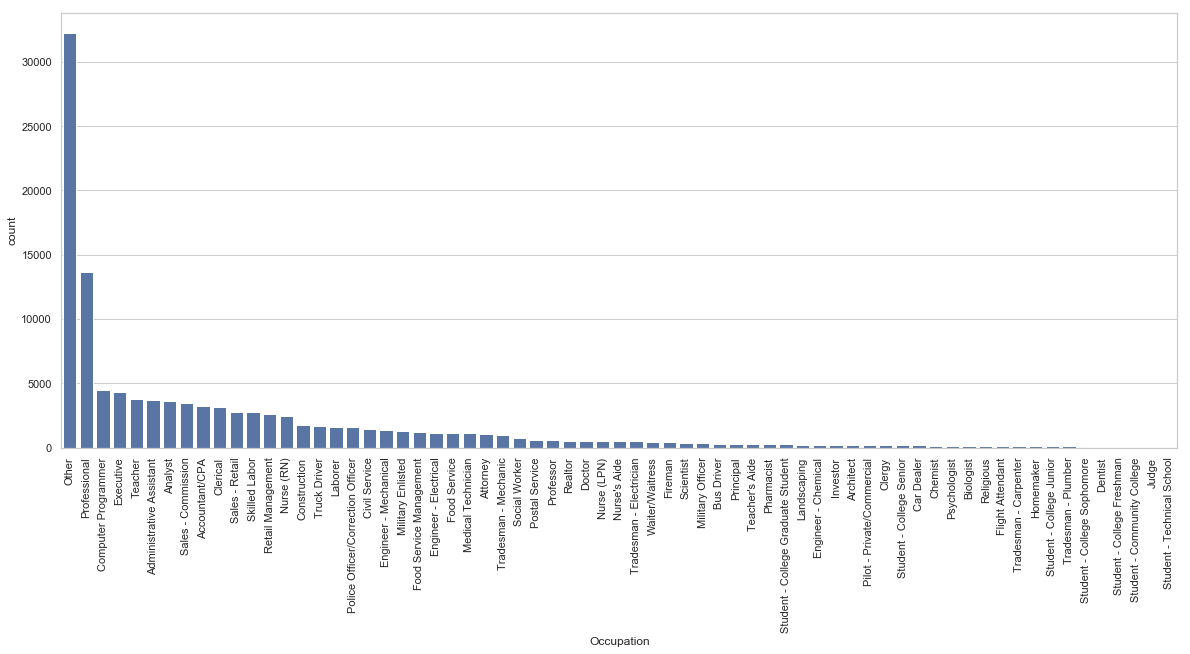

In [230]:
# let's do a bar plot
plt.figure(figsize = [20, 8])
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'Occupation',color=base_color, order=df['Occupation'].value_counts().index)
plt.xticks(rotation=90);

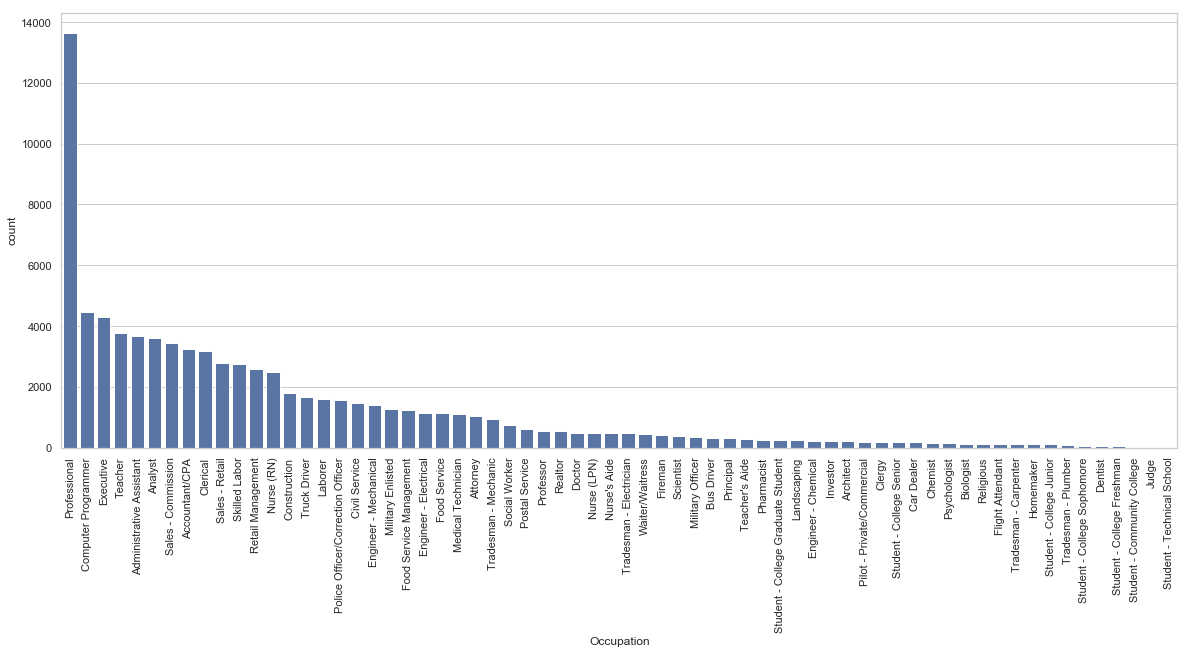

In [231]:
# let's show the values after "Others"

plt.figure(figsize = [20, 8])
sb.countplot(data = df, x = 'Occupation',color=base_color, 
             order=df['Occupation'].value_counts().iloc[1:].index)
plt.xticks(rotation=90);

`Comment`: Leaving the oocupation euqals to -_others"_ out gives a good picture on teh different professions, however most counted vales are Other and profeesional. So I'm in doubt if this information can provide meaningful insights.

### EmploymentStatus

In [107]:
df.EmploymentStatus.value_counts()

Employed         67322
Full-time        26355
Self-employed     6134
Not available     5347
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

`Comment`: Ok, let's move the NAs to the category "Others".

In [172]:
# change EmployeeStatus NAs to "Others"
df['EmploymentStatus'].fillna(df.EmploymentStatus.value_counts().index[4], inplace=True)
print(df['EmploymentStatus'].isna().sum())
df.EmploymentStatus.value_counts()
# change to categorial
df['EmploymentStatus'] = df['EmploymentStatus'].astype('category')

0


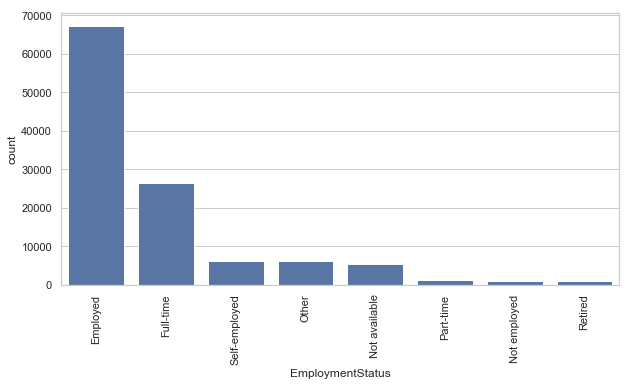

In [232]:
# let's do a bar plot
plt.figure(figsize = [10, 5])
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'EmploymentStatus',color=base_color, order=df['EmploymentStatus'].value_counts().index)
plt.xticks(rotation=90);

`Comment`: Most values are labeled as "Employed". 2nd highest is "Full-time" which could be as well "Employed". The same applies for "Part-time", where is the real distinguishing to "Employeed". 

### IsBorrowerHomeowner

In [135]:
sorted_counts=df.IsBorrowerHomeowner.value_counts().sort_values(ascending = False)
sorted_counts

True     57478
False    56459
Name: IsBorrowerHomeowner, dtype: int64

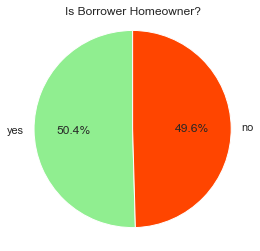

In [233]:
# plot a piechart 
plt.pie(sorted_counts, labels = ['yes', 'no'], startangle = 90, autopct='%1.1f%%', 
        counterclock = True, colors=['lightgreen','orangered']);
plt.axis('square')
plt.title('Is Borrower Homeowner?');


`Comment`: Nearly evenly distributed, this is nice and can be analyzed further. In Bivariate e.g. together with income etc...


### BorrowerState

In [167]:
df.BorrowerState.value_counts(normalize=True)

CA    0.135738
TX    0.063105
NY    0.062063
FL    0.061980
IL    0.054611
GA    0.046190
OH    0.038710
MI    0.033139
VA    0.030234
NJ    0.028564
NC    0.028444
WA    0.028112
PA    0.027411
MD    0.026019
MO    0.024119
MN    0.021379
MA    0.020678
CO    0.020383
IN    0.019166
AZ    0.017533
WI    0.016989
OR    0.016759
TN    0.016021
AL    0.015486
CT    0.015006
SC    0.010348
NV    0.010053
KS    0.009795
KY    0.009066
OK    0.008956
LA    0.008799
UT    0.008089
AR    0.007886
MS    0.007259
NE    0.006216
ID    0.005525
NH    0.005082
NM    0.004353
RI    0.004012
HI    0.003772
WV    0.003606
DC    0.003523
MT    0.003044
DE    0.002767
VT    0.001909
AK    0.001845
SD    0.001743
IA    0.001716
WY    0.001383
ME    0.000932
ND    0.000480
Name: BorrowerState, dtype: float64

In [149]:
# Missing Values
df.BorrowerState.isnull().sum()

5515

In [ ]:
# Let's distribute the NAs propotional to the States observed
# https://stackoverflow.com/questions/44867219/pandas-filling-na-values-to-be-filled-based-on-distribution-of-existing-values

In [168]:
null_counts = df.BorrowerState.value_counts(normalize=True)
len(null_counts)

51

In [174]:
# assign the missing values
missing = df['BorrowerState'].isnull()
# take a sample from the missing states based on the proportion (probability) of it's counts and assign it to the
# missing values
df.loc[missing,'BorrowerState'] = np.random.choice(null_counts.index, size=len(df[missing]),p=null_counts.values)
# change to categorial
df['BorrowerState'] = df['BorrowerState'].astype('category')
print(df.BorrowerState.isnull().sum())

0


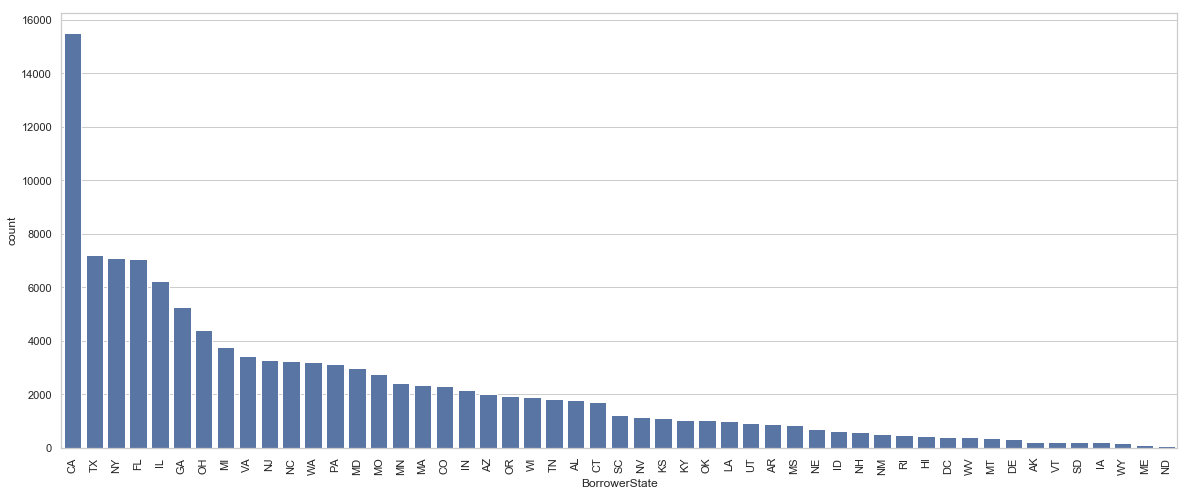

In [234]:
# let's show the values after "Others"
plt.figure(figsize = [20, 8])
sb.countplot(data = df, x = 'BorrowerState',color=base_color, 
             order=df['BorrowerState'].value_counts().index)
plt.xticks(rotation=90);

`Comments`: Ok, California is leading clearly that distribution, might be that all of those "Computer Programmers" are located in Silicon Valley. 

### ListingCategory


In [185]:
df.ListingCategory_numeric.value_counts(normalize=True)

1     0.511756
0     0.148898
7     0.092104
2     0.065238
3     0.063096
6     0.022574
4     0.021020
13    0.017518
15    0.013358
18    0.007767
14    0.007688
20    0.006767
19    0.006741
5     0.006635
16    0.002668
11    0.001905
8     0.001747
10    0.000799
9     0.000746
12    0.000518
17    0.000456
Name: ListingCategory_numeric, dtype: float64

In [216]:
# transform the variable
## step 1: create a pandas series index 0 = Not Avalibale....
data = np.array(['Not Available','Debt Consolidation','Home Improvement','Business',
                 'Personal Loan','Student Use','Auto','Other','Baby&Adoption',
                 'Boat','Cosmetic Procedure','Engagement Ring','Green Loans','Household Expenses',
                 'Large Purchases','Medical/Dental','Motorcycle','RV','Taxes',
                 'Vacation','Wedding Loans'])
listing_category_alpha = pd.Series(data)

In [220]:
## Step 2 define a function which gives based on zeh index the cat string
def trans_2_cat(x):
    category = listing_category_alpha[x]
    return category
## create a new attribute 
df['ListingCategory_alpha'] = df['ListingCategory_numeric'].apply(trans_2_cat)
## transform to categorial
df['ListingCategory_alpha'] = df['ListingCategory_alpha'].astype('category')

In [221]:
df.ListingCategory_alpha.value_counts(normalize=True)

Debt Consolidation    0.511756
Not Available         0.148898
Other                 0.092104
Home Improvement      0.065238
Business              0.063096
Auto                  0.022574
Personal Loan         0.021020
Household Expenses    0.017518
Medical/Dental        0.013358
Taxes                 0.007767
Large Purchases       0.007688
Wedding Loans         0.006767
Vacation              0.006741
Student Use           0.006635
Motorcycle            0.002668
Engagement Ring       0.001905
Baby&Adoption         0.001747
Cosmetic Procedure    0.000799
Boat                  0.000746
Green Loans           0.000518
RV                    0.000456
Name: ListingCategory_alpha, dtype: float64

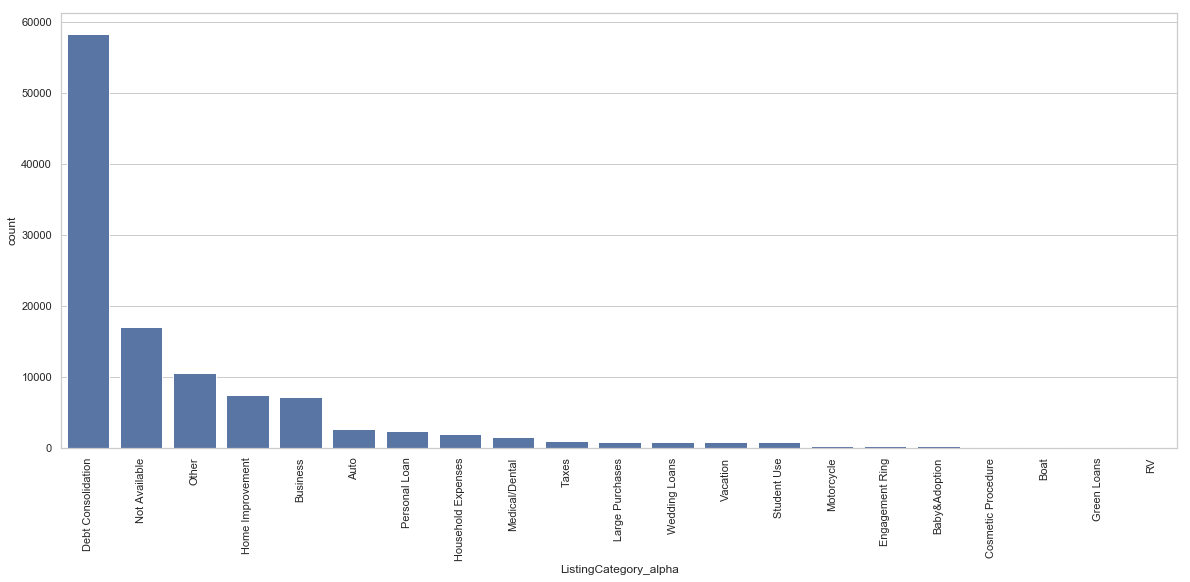

In [235]:
# let's visualize
plt.figure(figsize = [20, 8])
sb.countplot(data = df, x = 'ListingCategory_alpha',color=base_color, 
             order=df['ListingCategory_alpha'].value_counts().index)
plt.xticks(rotation=90);

`Comment`: This is not a surprise, actually in the various articles I read about P2P lending, it is often mentioned that this type of loan is ideal to consolidate different loans includimg credit card debts. Here we can see that more then the half of lall loans are used for that pirpose

### BorrowerAPR

In [223]:
df.BorrowerAPR.describe()

count    113912.000000
mean          0.218828
std           0.080364
min           0.006530
25%           0.156290
50%           0.209760
75%           0.283810
max           0.512290
Name: BorrowerAPR, dtype: float64

In [ ]:
# histogram, QQ Plot, 

In [236]:
# 3 and 7
BorrowerAPR_min = df.BorrowerAPR.min()
BorrowerAPR_max = df.BorrowerAPR.max()
number_of_values = df.shape[0]

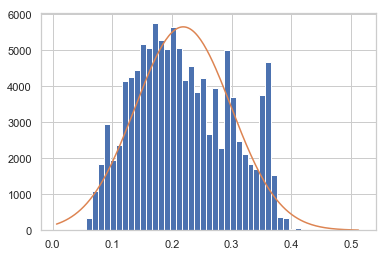

In [240]:
# create a histogram of the data
bin_size = 0.01
bin_edges = np.arange(BorrowerAPR_min, BorrowerAPR_max + bin_size, bin_size)
plt.hist(data = df, x = 'BorrowerAPR', bins = bin_edges);


# overlay a theoretical normal distribution on top
samp_mean = df['BorrowerAPR'].mean()
samp_sd = df['BorrowerAPR'].std()
x = np.linspace(BorrowerAPR_min, BorrowerAPR_max, 200)
y = norm.pdf(x, samp_mean, samp_sd) # normal distribution heights
y *= number_of_values * bin_size # scale the distribution height
plt.plot(x, y);

    + BorrowerAPR
    + BorrowerRate
    + ProsperRating
+ What is primarily influenicng the interest rate? (is it related to scoring, income and history)
    + ProsperRating (Alpha)
    + ProsperScore
    + DebtToIncomeRatio
    + IncomeRange

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

In [7]:
type(null_counts)

pandas.core.series.Series

In [8]:
null_counts.to_clipboard()